In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchinfo import summary
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl

# **NEURAL NETWORKS AND DEEP LEARNING**

---
### A.A. 2021/22 (6 CFU) - Dr. Alberto Testolin, Dr. Umberto Michieli
---

| **Student**             | **Degree**        | **ID**    | **Contact**                               |
|-------------------------|-------------------|-----------|-------------------------------------------|
| _Giacomo Franceschetto_ | _Physics of Data_ | _2053348_ | _giacomo.franceschetto@studenti.unipd.it_ |

# _Homework 2 - Unsupervised Deep Learning_

## Introduction

In this homework we are going to study machine learning models for learning how to solve unsupervised problems. Unsupervised problems are becoming more and more common, especially in the modern world of big data it is often the case that there is no labeled dataset. Unsupervised deep learning models are trained on these types of datasets and learn an internal representation of the samples and try to exploit the large amount of raw information in them. These models can then be used either to generate new samples from the internal representation or to solve supervised problems if manipulated with the right techniques.

Firstly, we will test and implement an convolutional autoencoder over the Fashion-MNIST dataset. An autoencoder consist in an architecture characterized by a bottleneck in the middle of an encoder and a decoder, starting from a sample the model learns its internal representation (_encoding_) and then try to reproduce it starting from the _latent_ space representation (_decoding_). In this homework we are going to test pytorch lightning, a ML developing framework that allows you to better organize your code and has enhanced flexibily features. The model optimization routine instead, will be performed with Optuna, as in the previous homework.

As mentioned before, unsupervised model can be fine tuned to solve supervised problems. Indeed, we will exploit the encoder from the trained convolutional autoencoder and use it as a supervised model appending a simple feed forward neural network at the end of it. We are also interested in comparing these results with the one of the CNN trained on the same task of the previous homework, is there an advantage in learning the _latent_ space representation? 

In fact, the core of unsupervised deep learning models is based on the internal representation of the dataset, therefore we proceed to visualise and analyse it using different feature-reduction techniques (PCA/t-SNE) and try to generate samples from random points in latent space.

In the end, we will test another kind of autoencoder model, the variational autoencoder.

In [4]:
# setup device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using {device}')

Using cpu


## Dataset

Pytorch Lightning (pl) provides also a useful DataModule class, in the following lines we are going to see the standard Dataset definition/download/tranform/dataloader routine and how it can be wrapped with the _pl.DataModule_ class.

### Standard routine
### Download

In [5]:
### Download the data and create dataset
data_dir = 'dataset'
# With these commands the train and test datasets, respectively, are downloaded 
# automatically and stored in the local "data_dir" directory.
train_dataset = torchvision.datasets.FashionMNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.FashionMNIST(data_dir, train=False, download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/train-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to dataset/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting dataset/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/FashionMNIST/raw



#### Visualize

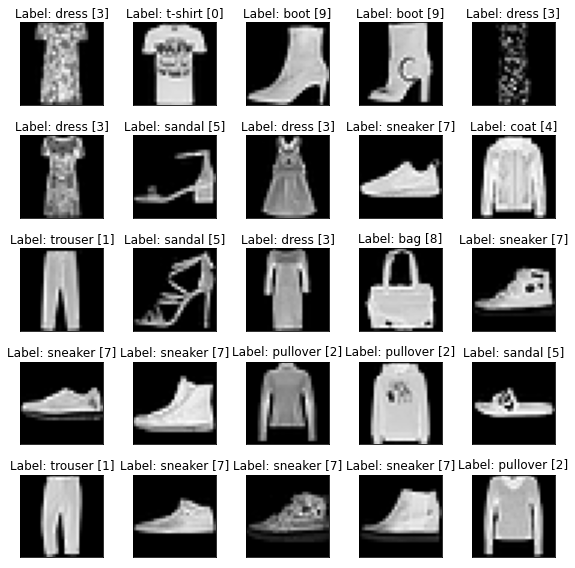

In [8]:
### Plot some samples
label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
             'sneaker','bag','boot']
fig, axs = plt.subplots(5, 5, figsize=(8,8))
for ax in axs.flatten():
    # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
    img, label = random.choice(train_dataset)
    ax.imshow(np.array(img), cmap='gist_gray')
    ax.set_title(f'Label: {label_names[label]} [{label}]')
    ax.set_xticks([])
    ax.set_yticks([])
plt.tight_layout()

#### Transform

In [2]:
# In this case the train_transform and test_transform are the same, 
# but we keep them separate for potential future updates
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

In [11]:
# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

#### Train Val split

In [14]:
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.2, random_state=79)

#### Dataloader

In [12]:
### Define train dataloader
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
### Define validation dataloader
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)
### Define test dataloader
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

### Lightning Dataset Class

In [45]:
class Fashion_DataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size, train_transform, test_transform, test_size=0.2, random_state=79):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_transform = train_transform
        self.test_transform = test_transform
        

    def prepare_data(self):
        # download
        torchvision.datasets.FashionMNIST(self.data_dir, train=True, download=True)
        torchvision.datasets.FashionMNIST(self.data_dir, train=False, download=True)

    def setup(self, stage=None):
        if stage == "fit" or stage is None:
            full_dataset = torchvision.datasets.FashionMNIST(self.data_dir, train=True, download=False, transform=self.train_transform)
            
            # split data
            self.train_dataset, self.val_dataset = train_test_split(full_dataset, test_size=0.2, random_state=79)

        if stage == "test" or stage is None:
            self.test_dataset = torchvision.datasets.FashionMNIST(self.data_dir, train=False, download=False, transform=self.test_transform)
    
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

    def predict_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)

    def get_train_item(self, idx):
        return self.train_dataset[idx]

In [27]:
# quick test
dataset = Fashion_DataModule(data_dir, 256, train_transform, test_transform)
dataset.prepare_data()
dataset.setup()

In [31]:
# test the get_train_item function
img, label = dataset.get_train_item(0)

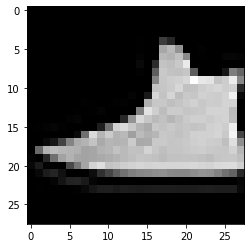

In [30]:
plt.imshow(img.squeeze(), cmap='gist_gray')

Defining your dataset as a datamodule is convient if you want to work then with pl-based models. 

Notice that we have not defined a k-fold cross validation routine, as in the previous homework we prefer to avoid this due to the size of our dataset and work with a simpler 80/20 split between train and validation data.

## Convolutional autoencoder

Now we are going to define our convolutional autoencoder model. We start from the CNN structure analog to the one used in the last homework, but with an initial convolutional layer of 8 channels that process the input sample:
- convolutional layer with 8 channels and 3x3 filter, stride 2 and padding 1
- convolutional layer with 16 channels and 3x3 filter, stride 2 and padding 1
- convolutional layer with 32 channels and 3x3 filter, stride 2 and padding 0

A feed forward neural network (3*3*32, 64, _latent_space_dim_) follows the convolutional layers, where _latent_space_dim_ is the dimensionality of the internal representation space of the network and can be tuned changing the input parameter. A symmetrical architecture reconstruct the image starting from the latent space representation (_decoder_).

After having defined the architecture, we develop also the classical _forward_ method (going only through the encoder for reasons that will become clear later), and the _train/val/tes_ step methods. These last method are going to be automatically called by the model class during the training process given the diferent stage of the training/evaluation. Every time we use the _self.log_ sintax, we are taking note of the current metric and saving it inside the class. This time only l2 regularization is considered and it is tuned through the _weight_decay_ parameter of the optimizer. As loss function we use the _MSE_, a simple method to consider the difference between two images is indeed looking at the single pixels values. No activation function is used at the end of the encoder instead at the end of the decoder we use a sigmoid to proper tune the domain of the outputs. 


In [4]:
class ConvoutionalAutoEncoder(pl.LightningModule):
 
    def __init__(self, latent_space_dim=2, optimizer_name='Adam', lr=1e-3, l2_reg=0.0):

        super().__init__()

        # store inputsinside the class                                    
        self.save_hyperparameters()
        
        # encoder
        self.encoder = nn.Sequential(
            # convloutional layers
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),                                                                            
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),                                                                          
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0),            
            nn.ReLU(),           
            # flattening                                                                  
            nn.Flatten(start_dim=1),
            # fully connected layers                                                                   
            nn.Linear(in_features=3*3*32, out_features=64),                                            
            nn.ReLU(),                                                                             
            nn.Linear(in_features=64, out_features=self.hparams.latent_space_dim)                                 
        )

        # decoder
        self.decoder = nn.Sequential(
            # fully connected layers
            nn.Linear(in_features=self.hparams.latent_space_dim, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=3*3*32),
            nn.ReLU(),
            # unflattening
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            # convloutional layers
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self,  x):
        x = self.encoder(x)
        return x

    def training_step(self, batch, batch_idx,  loss_name='train_loss'):
        x, _ = batch # we don't need labels for autoencoder

        # encode
        z = self.encoder(x)

        # decode
        x_hat = self.decoder(z)

        # calculate loss
        loss = nn.functional.mse_loss(x, x_hat) 
        self.log(loss_name, loss)

        return loss

    def validation_step(self, batch, batch_idx, loss_name='val_loss'):
        x, _ = batch

        # encode
        z = self.encoder(x)

        # decode
        x_hat = self.decoder(z)

        # calculate loss
        loss = nn.functional.mse_loss(x, x_hat)
        self.log(loss_name, loss)

        return loss

    def test_step(self, batch, batch_idx, loss_name='test_loss'):
        return self.validation_step(batch, batch_idx, loss_name)

    def configure_optimizers(self):
        # get params
        optimizer_name = self.hparams.optimizer_name
        lr = self.hparams.lr
        l2_reg = self.hparams.l2_reg

        optimizer = getattr(optim, optimizer_name)(self.parameters(), lr=lr, weight_decay=l2_reg)
        return optimizer

Few callbacks can be useful to keep track of the training process:
- _MetricsCallback_ saves the metrics values along the training process
- _RecImgDuringTrainingCallback_ allow us to plot the current reconstruction state during the training every n epochs
- _EarlyStoppingCallback_ implement early stopping procedure with tunable patience and delta parameters

In [273]:
class MetricsCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.metrics = []

    def on_validation_end(self, trainer, pl_module):
        self.metrics.append({k: v.item() for (k, v) in trainer.callback_metrics.items()})
        
class RecImgDuringTrainingCallback(pl.Callback):

    def __init__(self, input_img, every_n_epochs=1):
        super().__init__()
        self.input_img = input_img 
        self.every_n_epochs = every_n_epochs

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct image
            input_img = self.input_img
            with torch.no_grad():
                pl_module.eval()
                latent_img = pl_module.encoder(self.input_img)
                rec_img    = pl_module.decoder(latent_img)
                pl_module.train()
                
            input_img = self.input_img.squeeze().cpu().numpy()
            rec_img = rec_img.squeeze().cpu().numpy()
            
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.suptitle('Epoch: {}'.format(trainer.current_epoch))
            
            ax1.imshow(input_img, cmap='gist_gray')
            ax1.set_title('Original image')
            ax1.set_xticks([]); ax1.set_yticks([])
            
            ax2.imshow(rec_img, cmap='gist_gray')
            ax2.set_title('Reconstructed image')
            ax2.set_xticks([]); ax2.set_yticks([])
            
            plt.show()

In [6]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

In [94]:
# define trainer
metrics_callback = MetricsCallback()
trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_epochs=100,
                     callbacks=[metrics_callback,
                                EarlyStopping(monitor='val_loss', verbose=True), 
                                RecImgDuringTrainingCallback(dataset.get_train_item(0)[0].unsqueeze(0), every_n_epochs=10)])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [95]:
# define model
model = ConvoutionalAutoEncoder(latent_space_dim=2, optimizer_name='Adam', lr=1e-3, l2_reg=1e-5)

In [96]:
data_module = Fashion_DataModule(data_dir, 256, train_transform, test_transform)


  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.5 K
1 | decoder | Sequential | 24.8 K
---------------------------------------
49.3 K    Trainable params
0         Non-trainable params
49.3 K    Total params
0.197     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.055


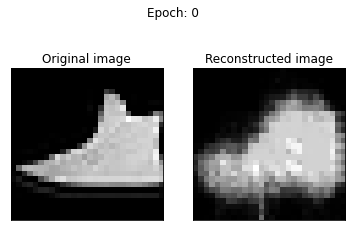

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 0.041


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.039


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.037


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.035


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.034


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.033


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.032


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.032


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.031


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.031


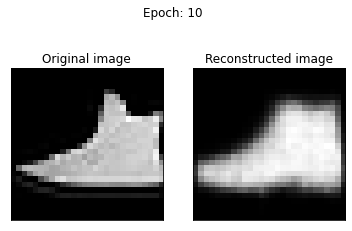

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.031


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.031


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.030


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.030


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.030


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.030


Validation: 0it [00:00, ?it/s]

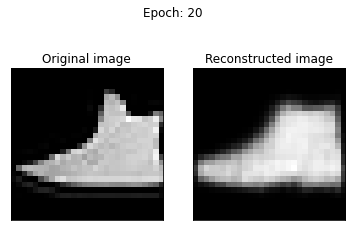

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.030


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.029


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.029


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.029


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.029


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.029


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.029


Validation: 0it [00:00, ?it/s]

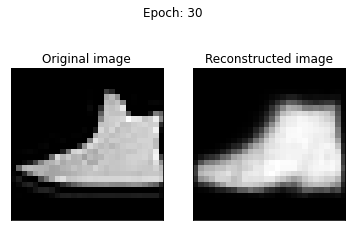

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.029


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.029


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.029


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


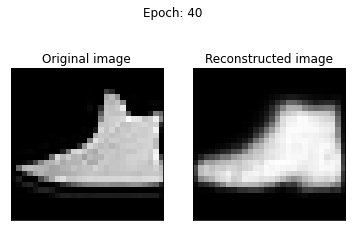

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


Validation: 0it [00:00, ?it/s]

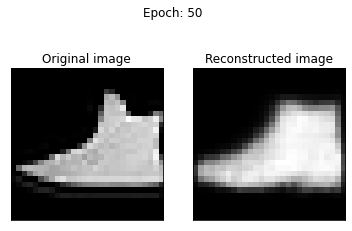

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.028


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 0.028. Signaling Trainer to stop.


In [97]:
trainer.fit(model, data_module)

In [37]:
def plot_metrics(metrics_callback, title, metric, logy=False, acc=False):
    train_loss = [metric['train_loss'] for metric in metrics_callback.metrics[1:]]
    val_loss = [metric['val_loss'] for metric in metrics_callback.metrics[1:]]
    if acc:
        train_acc = np.array([metric['train_acc'] for metric in metrics_callback.metrics[1:]])
        val_acc = np.array([metric['val_acc'] for metric in metrics_callback.metrics[1:]])

    x = np.arange(len(train_loss)) + 1

    fig, ax = plt.subplots( figsize=(10, 6))

    ax.plot(x, train_loss, label='Train Loss')
    ax.plot(x, val_loss, label='Validation Loss')
    if acc:
        ax.plot(x, 1-train_acc, label='Train Accuracy')
        ax.plot(x, 1-val_acc, label='Validation Accuracy')
    ax.set_xlabel("epoch")
    ax.set_ylabel(metric)
    if logy: ax.set_yscale("log")
    ax.legend()
    ax.set_title(title)

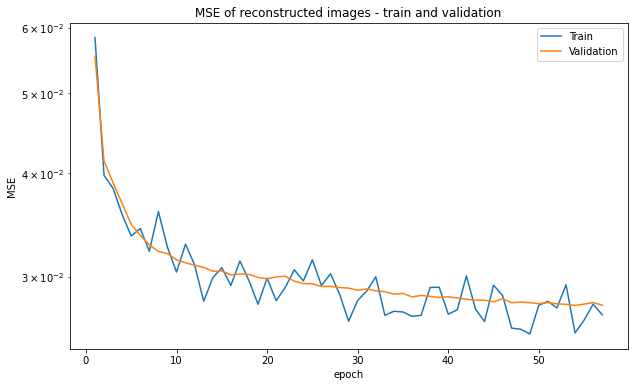

In [125]:
title = "MSE of reconstructed images - train and validation"
metric = "MSE"
plot_metrics(metrics_callback, title, metric, logy=True)

In [ ]:
trainer.test(model, data_module)

In [263]:
def plot_recos(model, data_module, n, figsize=(20,8), variational=False):
    ### Plot reconstructions
    label_names=['t-shirt','trouser','pullover','dress','coat','sandal','shirt',
                'sneaker','bag','boot']
    fig, axs = plt.subplots(round(n/3), 6, figsize=figsize)
    for i in range(0, n*2, 2):
        # random.choice allows to randomly sample from a list-like object (basically anything that can be accessed with an index, like our dataset)
        img, label = random.choice(data_module.train_dataset)
        axs[(i)//6, (i)%6].imshow(np.array(img.squeeze().cpu().numpy()), cmap='gist_gray')
        axs[(i)//6, (i)%6].set_title(f'Orig: {label_names[label]} [{label}]')

        with torch.no_grad():
            model.eval()
            if variational:
                rec_img, _, _ = model(img.unsqueeze(0))
            else:
                latent_img = model.encoder(img.unsqueeze(0))
                rec_img = model.decoder(latent_img)
        
        axs[(i)//6, (i)%6+1].imshow(rec_img.squeeze().cpu().numpy(), cmap='gist_gray')
        axs[(i)//6, (i)%6+1].set_title(f'Rec: {label_names[label]} [{label}]')

    plt.tight_layout()

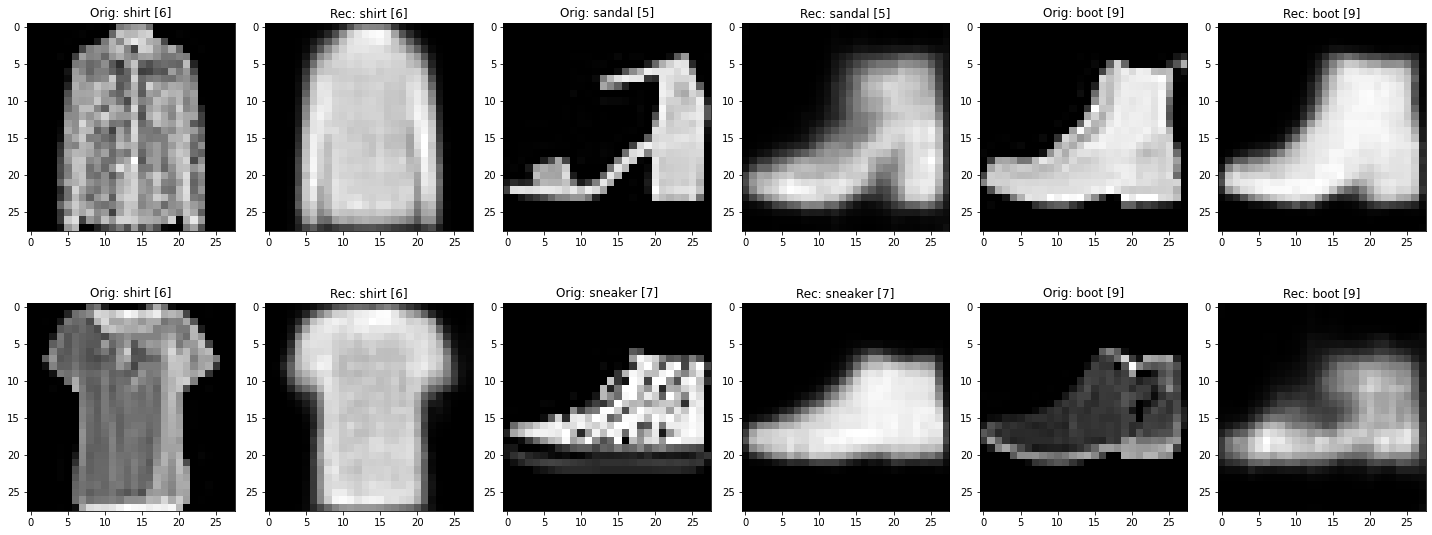

In [184]:
plot_recos(model, data_module, 6)

Already this first model gives good results, we can observe how the training process improve the model performance epoch by epoch thanks to the _RecImgDuringTrainingCallback_. Moreover, thanks to the final results plots, we can state that the model have learnt to distinguish basic items but struggle with similar objects (e.g. sandal/boot/sneaker)

## Hyperparameters tuning

As usual, we proceed with the optimisation of the hyperparameters of the model, this time, in addition to the usual parameters such as optimiser, learning rate and l2 regularisation lambda parameter, we are very interested in the number of dimensions of the latent space. For this last parameter, we consider between 2 and 10 dimensions. Although intuitively, the larger the size of the latent space, the more information will be saved and the better the reconstruction will perform, it may be that with a space with an excessive number of dimensions, in addition to the necessary information, noise will also be accumulated, which will impair performance.

In [266]:
import optuna

In [267]:
def objective(trial, data_module):
    # sample hyperparameters
    hparams = {
              'latent_space_dim': trial.suggest_int('latent_space_dim', 2, 10),
              'optimizer_name': trial.suggest_categorical("optimizer_name", ["Adam", "RMSprop", "SGD"]),
              'lr': trial.suggest_loguniform('lr', 1e-5, 1e-1),
              'l2_reg': trial.suggest_loguniform('l2_reg', 1e-5, 1e-1),
              }
    
    # define trainer
    trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                        max_epochs=20,
                        callbacks=[EarlyStopping(monitor='val_loss')])

    # define model
    model = ConvoutionalAutoEncoder(**hparams)

    # fit model
    trainer.fit(model, data_module)
    
    val_mse_loss = trainer.callback_metrics['val_loss'].item()

    return val_mse_loss

In [268]:
dummy_objective = lambda trial: objective(trial, data_module)
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(dummy_objective, n_trials=100)

[I 2022-09-10 01:30:33,394] A new study created in memory with name: no-name-9397f145-a0c9-4a93-ad8e-6d72b82bd596
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.8 K
1 | decoder | Sequential | 25.1 K
---------------------------------------
49.9 K    Trainable params
0         Non-trainable params
49.9 K    Total params
0.200     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 01:33:30,582] Trial 0 finished with value: 0.09400029480457306 and parameters: {'latent_space_dim': 7, 'optimizer_name': 'Adam', 'lr': 1.9529490339762705e-05, 'l2_reg': 0.0008196227471127836}. Best is trial 0 with value: 0.09400029480457306.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.7 K
1 | decoder | Sequential | 25.0 K
---------------------------------------
49.7 K    Trainable params
0         Non-trainable params
49.7 K    Total params
0.199     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 01:38:09,588] Trial 1 finished with value: 0.028032101690769196 and parameters: {'latent_space_dim': 5, 'optimizer_name': 'RMSprop', 'lr': 0.0004606033629893588, 'l2_reg': 0.0001479854838734417}. Best is trial 1 with value: 0.028032101690769196.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 01:40:57,388] Trial 2 finished with value: 0.15061530470848083 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'SGD', 'lr': 0.0008119310390180023, 'l2_reg': 0.07431620797349352}. Best is trial 1 with value: 0.028032101690769196.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.6 K
1 | decoder | Sequential | 24.9 K
---------------------------------------
49.5 K    Trainable params
0         Non-trainable params
49.5 K    Total params
0.198     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 01:44:39,342] Trial 3 finished with value: 0.08767233043909073 and parameters: {'latent_space_dim': 4, 'optimizer_name': 'RMSprop', 'lr': 3.582161400622569e-05, 'l2_reg': 0.0006855637490404354}. Best is trial 1 with value: 0.028032101690769196.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.8 K
1 | decoder | Sequential | 25.1 K
---------------------------------------
49.9 K    Trainable params
0         Non-trainable params
49.9 K    Total params
0.200     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 01:46:32,086] Trial 4 finished with value: 0.12951867282390594 and parameters: {'latent_space_dim': 7, 'optimizer_name': 'RMSprop', 'lr': 0.0007504866472610787, 'l2_reg': 0.056093052905029896}. Best is trial 1 with value: 0.028032101690769196.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.5 K
1 | decoder | Sequential | 24.8 K
---------------------------------------
49.3 K    Trainable params
0         Non-trainable params
49.3 K    Total params
0.197     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 01:50:20,920] Trial 5 finished with value: 0.06604801118373871 and parameters: {'latent_space_dim': 2, 'optimizer_name': 'Adam', 'lr': 0.00010717631760577766, 'l2_reg': 0.0010363621331492777}. Best is trial 1 with value: 0.028032101690769196.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.7 K
1 | decoder | Sequential | 25.0 K
---------------------------------------
49.7 K    Trainable params
0         Non-trainable params
49.7 K    Total params
0.199     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 01:54:32,381] Trial 6 finished with value: 0.10940839350223541 and parameters: {'latent_space_dim': 5, 'optimizer_name': 'RMSprop', 'lr': 3.677973056108275e-05, 'l2_reg': 0.0008733296806376893}. Best is trial 1 with value: 0.028032101690769196.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.6 K
1 | decoder | Sequential | 24.9 K
---------------------------------------
49.5 K    Trainable params
0         Non-trainable params
49.5 K    Total params
0.198     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 01:57:02,233] Trial 7 finished with value: 0.1245540902018547 and parameters: {'latent_space_dim': 4, 'optimizer_name': 'RMSprop', 'lr': 0.0010246962717846086, 'l2_reg': 0.006773179628740705}. Best is trial 1 with value: 0.028032101690769196.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.6 K
1 | decoder | Sequential | 24.9 K
---------------------------------------
49.5 K    Trainable params
0         Non-trainable params
49.5 K    Total params
0.198     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 01:58:53,928] Trial 8 finished with value: 0.06377142667770386 and parameters: {'latent_space_dim': 4, 'optimizer_name': 'Adam', 'lr': 0.007433992642300096, 'l2_reg': 0.0008517880050837818}. Best is trial 1 with value: 0.028032101690769196.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:03:12,082] Trial 9 finished with value: 0.028492512181401253 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.00025430555570906375, 'l2_reg': 0.0006855941645450116}. Best is trial 1 with value: 0.028032101690769196.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.5 K
1 | decoder | Sequential | 24.8 K
---------------------------------------
49.3 K    Trainable params
0         Non-trainable params
49.3 K    Total params
0.197     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:06:24,665] Trial 10 finished with value: 0.12432047724723816 and parameters: {'latent_space_dim': 2, 'optimizer_name': 'SGD', 'lr': 0.05542544571805964, 'l2_reg': 1.0945672175503447e-05}. Best is trial 1 with value: 0.028032101690769196.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:09:42,150] Trial 11 finished with value: 0.02259047143161297 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.000233079694200391, 'l2_reg': 5.719629155044059e-05}. Best is trial 11 with value: 0.02259047143161297.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.9 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.1 K    Trainable params
0         Non-trainable params
50.1 K    Total params
0.200     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:13:42,801] Trial 12 finished with value: 0.016747361049056053 and parameters: {'latent_space_dim': 8, 'optimizer_name': 'Adam', 'lr': 0.005058079059162346, 'l2_reg': 5.248441297745457e-05}. Best is trial 12 with value: 0.016747361049056053.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:17:13,657] Trial 13 finished with value: 0.01671086810529232 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.007143542494407856, 'l2_reg': 2.0825123346935775e-05}. Best is trial 13 with value: 0.01671086810529232.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.9 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.1 K    Trainable params
0         Non-trainable params
50.1 K    Total params
0.200     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:21:22,894] Trial 14 finished with value: 0.015541905537247658 and parameters: {'latent_space_dim': 8, 'optimizer_name': 'Adam', 'lr': 0.0062717880616213455, 'l2_reg': 1.1547307372597887e-05}. Best is trial 14 with value: 0.015541905537247658.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.9 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.1 K    Trainable params
0         Non-trainable params
50.1 K    Total params
0.200     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:23:46,819] Trial 15 finished with value: 0.016751820221543312 and parameters: {'latent_space_dim': 8, 'optimizer_name': 'Adam', 'lr': 0.016569258489071606, 'l2_reg': 1.3484778176529711e-05}. Best is trial 14 with value: 0.015541905537247658.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:27:24,407] Trial 16 finished with value: 0.01623028889298439 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.004172833923244135, 'l2_reg': 4.731741915002851e-05}. Best is trial 14 with value: 0.015541905537247658.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.8 K
1 | decoder | Sequential | 25.1 K
---------------------------------------
49.9 K    Trainable params
0         Non-trainable params
49.9 K    Total params
0.200     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:30:30,880] Trial 17 finished with value: 0.1231471449136734 and parameters: {'latent_space_dim': 7, 'optimizer_name': 'SGD', 'lr': 0.075412875390596, 'l2_reg': 0.00015406257645436767}. Best is trial 14 with value: 0.015541905537247658.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:34:24,243] Trial 18 finished with value: 0.016265466809272766 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.002550302277367455, 'l2_reg': 3.888191219838118e-05}. Best is trial 14 with value: 0.015541905537247658.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.9 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.1 K    Trainable params
0         Non-trainable params
50.1 K    Total params
0.200     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:36:29,730] Trial 19 finished with value: 0.024074068292975426 and parameters: {'latent_space_dim': 8, 'optimizer_name': 'Adam', 'lr': 0.024035411006967586, 'l2_reg': 0.0002003650087068085}. Best is trial 14 with value: 0.015541905537247658.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.8 K
1 | decoder | Sequential | 25.0 K
---------------------------------------
49.8 K    Trainable params
0         Non-trainable params
49.8 K    Total params
0.199     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:39:30,871] Trial 20 finished with value: 0.127945214509964 and parameters: {'latent_space_dim': 6, 'optimizer_name': 'SGD', 'lr': 0.0020794262015041668, 'l2_reg': 0.004287596342878812}. Best is trial 14 with value: 0.015541905537247658.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:43:04,158] Trial 21 finished with value: 0.016254553571343422 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.004034576773545302, 'l2_reg': 3.7245235216587446e-05}. Best is trial 14 with value: 0.015541905537247658.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:45:56,683] Trial 22 finished with value: 0.01854756660759449 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0027881530599245417, 'l2_reg': 2.755127241455533e-05}. Best is trial 14 with value: 0.015541905537247658.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:47:46,987] Trial 23 finished with value: 0.021865257993340492 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.022629848111726764, 'l2_reg': 6.669169260355546e-05}. Best is trial 14 with value: 0.015541905537247658.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.9 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.1 K    Trainable params
0         Non-trainable params
50.1 K    Total params
0.200     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:51:03,989] Trial 24 finished with value: 0.01919807866215706 and parameters: {'latent_space_dim': 8, 'optimizer_name': 'Adam', 'lr': 0.010999284586041142, 'l2_reg': 0.00010207274198754695}. Best is trial 14 with value: 0.015541905537247658.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:54:16,016] Trial 25 finished with value: 0.05703823268413544 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.0016809501507571891, 'l2_reg': 0.0003403319762448041}. Best is trial 14 with value: 0.015541905537247658.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 02:57:42,757] Trial 26 finished with value: 0.015695534646511078 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0043701511526055515, 'l2_reg': 2.036613393756871e-05}. Best is trial 14 with value: 0.015541905537247658.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:01:16,578] Trial 27 finished with value: 0.015117669478058815 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.012710752735792757, 'l2_reg': 1.624989798961624e-05}. Best is trial 27 with value: 0.015117669478058815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:02:36,657] Trial 28 finished with value: 0.08746681362390518 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.029760306168374995, 'l2_reg': 1.0075580316450724e-05}. Best is trial 27 with value: 0.015117669478058815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.8 K
1 | decoder | Sequential | 25.1 K
---------------------------------------
49.9 K    Trainable params
0         Non-trainable params
49.9 K    Total params
0.200     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:05:20,990] Trial 29 finished with value: 0.12415566295385361 and parameters: {'latent_space_dim': 7, 'optimizer_name': 'SGD', 'lr': 0.04376945562355317, 'l2_reg': 2.0483404083245743e-05}. Best is trial 27 with value: 0.015117669478058815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:08:48,923] Trial 30 finished with value: 0.015118502080440521 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.011631581337525959, 'l2_reg': 1.9385764558854468e-05}. Best is trial 27 with value: 0.015117669478058815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:12:34,030] Trial 31 finished with value: 0.015085367485880852 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.012108112135578821, 'l2_reg': 1.6664450032471722e-05}. Best is trial 31 with value: 0.015085367485880852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:16:20,515] Trial 32 finished with value: 0.0156693272292614 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.014787607798921146, 'l2_reg': 1.5687299328374282e-05}. Best is trial 31 with value: 0.015085367485880852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:18:14,759] Trial 33 finished with value: 0.02092290297150612 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.01129988606540589, 'l2_reg': 9.66590376270017e-05}. Best is trial 31 with value: 0.015085367485880852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.9 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.1 K    Trainable params
0         Non-trainable params
50.1 K    Total params
0.200     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:20:29,644] Trial 34 finished with value: 0.020759206265211105 and parameters: {'latent_space_dim': 8, 'optimizer_name': 'Adam', 'lr': 0.0384226319044263, 'l2_reg': 3.131382184233525e-05}. Best is trial 31 with value: 0.015085367485880852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.8 K
1 | decoder | Sequential | 25.0 K
---------------------------------------
49.8 K    Trainable params
0         Non-trainable params
49.8 K    Total params
0.199     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:24:42,656] Trial 35 finished with value: 0.14270184934139252 and parameters: {'latent_space_dim': 6, 'optimizer_name': 'RMSprop', 'lr': 0.09410099673043527, 'l2_reg': 1.0718795153770864e-05}. Best is trial 31 with value: 0.015085367485880852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:25:23,484] Trial 36 finished with value: 0.09246402978897095 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.008196238958023946, 'l2_reg': 0.0023061286271534734}. Best is trial 31 with value: 0.015085367485880852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.8 K
1 | decoder | Sequential | 25.1 K
---------------------------------------
49.9 K    Trainable params
0         Non-trainable params
49.9 K    Total params
0.200     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:29:49,041] Trial 37 finished with value: 0.03620776906609535 and parameters: {'latent_space_dim': 7, 'optimizer_name': 'RMSprop', 'lr': 0.0014424121649258203, 'l2_reg': 0.000297887066716208}. Best is trial 31 with value: 0.015085367485880852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:32:45,066] Trial 38 finished with value: 0.1559937596321106 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 1.2692565085644596e-05, 'l2_reg': 0.035859730879501964}. Best is trial 31 with value: 0.015085367485880852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.9 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.1 K    Trainable params
0         Non-trainable params
50.1 K    Total params
0.200     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:35:26,033] Trial 39 finished with value: 0.1405305713415146 and parameters: {'latent_space_dim': 8, 'optimizer_name': 'SGD', 'lr': 0.000593578409897214, 'l2_reg': 0.00010006278364463732}. Best is trial 31 with value: 0.015085367485880852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.7 K
1 | decoder | Sequential | 25.0 K
---------------------------------------
49.7 K    Trainable params
0         Non-trainable params
49.7 K    Total params
0.199     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:36:38,632] Trial 40 finished with value: 0.037727147340774536 and parameters: {'latent_space_dim': 5, 'optimizer_name': 'RMSprop', 'lr': 0.017303628459480958, 'l2_reg': 2.48525682800096e-05}. Best is trial 31 with value: 0.015085367485880852.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:40:14,066] Trial 41 finished with value: 0.014956950210034847 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.012794543911249871, 'l2_reg': 1.5650647945071933e-05}. Best is trial 41 with value: 0.014956950210034847.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:42:06,306] Trial 42 finished with value: 0.02001439407467842 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.01004403485208808, 'l2_reg': 1.4845643264508328e-05}. Best is trial 41 with value: 0.014956950210034847.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:43:30,329] Trial 43 finished with value: 0.12582239508628845 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.006754534688744602, 'l2_reg': 0.021812565317666965}. Best is trial 41 with value: 0.014956950210034847.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:45:59,907] Trial 44 finished with value: 0.016864433884620667 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.026056698699571144, 'l2_reg': 1.685930236117522e-05}. Best is trial 41 with value: 0.014956950210034847.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:49:10,374] Trial 45 finished with value: 0.01790851168334484 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.014359014950108972, 'l2_reg': 7.353842131757099e-05}. Best is trial 41 with value: 0.014956950210034847.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.6 K
1 | decoder | Sequential | 24.8 K
---------------------------------------
49.4 K    Trainable params
0         Non-trainable params
49.4 K    Total params
0.198     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:50:04,857] Trial 46 finished with value: 0.0278188306838274 and parameters: {'latent_space_dim': 3, 'optimizer_name': 'Adam', 'lr': 0.05435034928456162, 'l2_reg': 2.8308688880802578e-05}. Best is trial 41 with value: 0.014956950210034847.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:53:11,014] Trial 47 finished with value: 0.018272429704666138 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0010240558412239345, 'l2_reg': 4.1581412882284406e-05}. Best is trial 41 with value: 0.014956950210034847.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:56:14,686] Trial 48 finished with value: 0.024448061361908913 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'RMSprop', 'lr': 0.0034053401249762865, 'l2_reg': 1.0210938886562934e-05}. Best is trial 41 with value: 0.014956950210034847.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 03:59:35,747] Trial 49 finished with value: 0.01429621409624815 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.006071310449553573, 'l2_reg': 1.5515578605757934e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:01:10,055] Trial 50 finished with value: 0.02034112997353077 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.03534853461107463, 'l2_reg': 2.1581783943189924e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:05:08,878] Trial 51 finished with value: 0.014719204045832157 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.005570646715090056, 'l2_reg': 1.686453166141907e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:08:21,140] Trial 52 finished with value: 0.01568644680082798 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.005524819784015634, 'l2_reg': 3.1748466384467526e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:12:07,555] Trial 53 finished with value: 0.020244382321834564 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.01909053421173317, 'l2_reg': 5.77166325849342e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:16:19,937] Trial 54 finished with value: 0.015431013889610767 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.009213325804087244, 'l2_reg': 1.579196383605264e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:18:58,844] Trial 55 finished with value: 0.12463050335645676 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'SGD', 'lr': 0.012050710016579702, 'l2_reg': 4.3517595744149775e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:21:40,033] Trial 56 finished with value: 0.02640187367796898 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 6.475669616325716e-05, 'l2_reg': 1.5263810328509062e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:25:15,327] Trial 57 finished with value: 0.014520127326250076 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.006736205310686217, 'l2_reg': 2.268942562945259e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:28:58,366] Trial 58 finished with value: 0.06521259993314743 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.00031075605567246477, 'l2_reg': 0.001180182125996461}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:35:01,401] Trial 59 finished with value: 0.12492994964122772 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0024051600882318155, 'l2_reg': 0.011896463981744248}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.6 K
1 | decoder | Sequential | 24.8 K
---------------------------------------
49.4 K    Trainable params
0         Non-trainable params
49.4 K    Total params
0.198     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:38:16,888] Trial 60 finished with value: 0.02419191040098667 and parameters: {'latent_space_dim': 3, 'optimizer_name': 'Adam', 'lr': 0.0058265094968916456, 'l2_reg': 8.019196457819505e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:41:56,962] Trial 61 finished with value: 0.015037060715258121 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.00341188656301288, 'l2_reg': 2.513877998755314e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:45:42,409] Trial 62 finished with value: 0.015475863590836525 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0036053469046802163, 'l2_reg': 2.7286866101924194e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:48:41,625] Trial 63 finished with value: 0.016529666259884834 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.0014547052894899682, 'l2_reg': 1.3221030327739937e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:51:35,680] Trial 64 finished with value: 0.015763817355036736 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.007317980365298804, 'l2_reg': 3.763870595666024e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:54:42,362] Trial 65 finished with value: 0.019661512225866318 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0031477808562681937, 'l2_reg': 0.00014035396415369467}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 04:58:05,500] Trial 66 finished with value: 0.01779506355524063 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.020608965885398307, 'l2_reg': 5.252624189533288e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:00:44,321] Trial 67 finished with value: 0.1253008395433426 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'SGD', 'lr': 0.0048993366207223145, 'l2_reg': 2.1476188429885267e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:03:33,609] Trial 68 finished with value: 0.016091804951429367 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.0018477998806837393, 'l2_reg': 1.3086327960512337e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:06:31,228] Trial 69 finished with value: 0.029573185369372368 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'RMSprop', 'lr': 0.008120840450654608, 'l2_reg': 3.33208786104394e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:09:56,930] Trial 70 finished with value: 0.015734249725937843 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.013960956445626577, 'l2_reg': 1.8091986521510116e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:13:03,709] Trial 71 finished with value: 0.015011191368103027 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.010073928659409521, 'l2_reg': 2.376460434392867e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:16:18,630] Trial 72 finished with value: 0.014333189465105534 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.004647948071114298, 'l2_reg': 2.4745501107068476e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:19:41,903] Trial 73 finished with value: 0.014772213064134121 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.004972987148534502, 'l2_reg': 2.4964234791312762e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:22:44,612] Trial 74 finished with value: 0.016308413818478584 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.002748693461784966, 'l2_reg': 2.4810695975566317e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:25:35,406] Trial 75 finished with value: 0.016967598348855972 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.004486074166632092, 'l2_reg': 4.793500087105037e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:29:17,016] Trial 76 finished with value: 0.016000887379050255 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.006174918871031956, 'l2_reg': 2.3717564284110026e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:33:10,389] Trial 77 finished with value: 0.015044938772916794 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.004160130377572244, 'l2_reg': 1.1908785753525498e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:36:27,339] Trial 78 finished with value: 0.017081959173083305 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.002133380412753331, 'l2_reg': 3.674813144438517e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.9 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.1 K    Trainable params
0         Non-trainable params
50.1 K    Total params
0.200     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:39:05,834] Trial 79 finished with value: 0.124595507979393 and parameters: {'latent_space_dim': 8, 'optimizer_name': 'SGD', 'lr': 0.009473976316449372, 'l2_reg': 5.944051164905708e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:42:21,422] Trial 80 finished with value: 0.01785481534898281 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.001168607022561117, 'l2_reg': 2.9423912084395467e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:45:22,417] Trial 81 finished with value: 0.014817856252193451 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0038688420674533514, 'l2_reg': 1.1563659094832206e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:48:18,836] Trial 82 finished with value: 0.014627177268266678 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.00518050556156898, 'l2_reg': 1.2191706725433106e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:51:46,905] Trial 83 finished with value: 0.015322957187891006 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.005192435971441413, 'l2_reg': 1.2196291630507391e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:55:23,883] Trial 84 finished with value: 0.016558757051825523 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.006740374253657978, 'l2_reg': 1.8194509937439414e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 05:57:47,386] Trial 85 finished with value: 0.01611548475921154 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.007928342258725017, 'l2_reg': 1.3007738399968602e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.7 K
1 | decoder | Sequential | 25.0 K
---------------------------------------
49.7 K    Trainable params
0         Non-trainable params
49.7 K    Total params
0.199     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 06:00:38,774] Trial 86 finished with value: 0.01916181668639183 and parameters: {'latent_space_dim': 5, 'optimizer_name': 'Adam', 'lr': 0.01600506758263476, 'l2_reg': 1.04243337216509e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 24.8 K
1 | decoder | Sequential | 25.0 K
---------------------------------------
49.8 K    Trainable params
0         Non-trainable params
49.8 K    Total params
0.199     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 06:04:00,661] Trial 87 finished with value: 0.023660212755203247 and parameters: {'latent_space_dim': 6, 'optimizer_name': 'RMSprop', 'lr': 0.0007726567069252117, 'l2_reg': 1.809795546477691e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 06:05:59,899] Trial 88 finished with value: 0.06021822988986969 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.00937284191254376, 'l2_reg': 0.0005007072699609335}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 06:08:01,037] Trial 89 finished with value: 0.13415659964084625 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.0028093426202853732, 'l2_reg': 0.09785523980105763}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 06:09:56,918] Trial 90 finished with value: 0.019394060596823692 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.027702751886367144, 'l2_reg': 2.0981627595438873e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 06:13:12,065] Trial 91 finished with value: 0.015758419409394264 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.003594677059693587, 'l2_reg': 2.3524018614557324e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 06:16:31,813] Trial 92 finished with value: 0.015133270062506199 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.005400407652925563, 'l2_reg': 1.4342037820923984e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 06:20:01,244] Trial 93 finished with value: 0.016053058207035065 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.0041619590914336296, 'l2_reg': 2.7631335165546735e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 06:23:02,993] Trial 94 finished with value: 0.015517903491854668 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.00333952013741129, 'l2_reg': 3.3638715930194176e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 06:26:19,538] Trial 95 finished with value: 0.016799652948975563 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.002092494873305541, 'l2_reg': 4.424594733665508e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 06:29:33,133] Trial 96 finished with value: 0.015121135860681534 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'Adam', 'lr': 0.007219014858191324, 'l2_reg': 1.827809917609934e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 06:32:55,527] Trial 97 finished with value: 0.015015809796750546 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.011161976382446339, 'l2_reg': 1.2100606175172108e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 06:36:54,778] Trial 98 finished with value: 0.014430788345634937 and parameters: {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 0.010473584817159714, 'l2_reg': 1.4374193245433574e-05}. Best is trial 49 with value: 0.01429621409624815.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.2 K
---------------------------------------
50.2 K    Trainable params
0         Non-trainable params
50.2 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

[I 2022-09-10 06:39:36,579] Trial 99 finished with value: 0.1243061050772667 and parameters: {'latent_space_dim': 9, 'optimizer_name': 'SGD', 'lr': 0.020522927198551942, 'l2_reg': 1.4720086310576124e-05}. Best is trial 49 with value: 0.01429621409624815.


In [269]:
print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials: 100
Best trial:
  Value: 0.01429621409624815
  Params: 
    latent_space_dim: 10
    optimizer_name: Adam
    lr: 0.006071310449553573
    l2_reg: 1.5515578605757934e-05


Despite the discussion at the beginning of this section we observe that the maximum number available is selected for the _latent_space_dim_ parameter, maybe we could increase more the parameter domain if one is interested in understanding the boundary between information and noise in the interal representation space of the model.

## Training the best model

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 25.0 K
1 | decoder | Sequential | 25.3 K
---------------------------------------
50.3 K    Trainable params
0         Non-trainable params
50.3 K    Total params
0.201     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.028


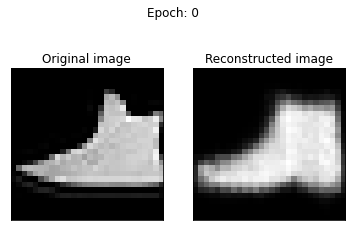

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.006 >= min_delta = 0.0. New best score: 0.022


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.020


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.020


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.020


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.020


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.018


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.018


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.018


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.017


Validation: 0it [00:00, ?it/s]

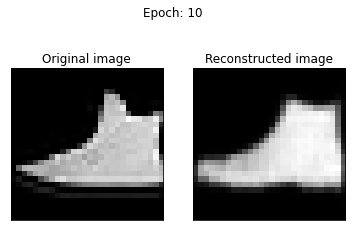

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.017


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.016


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.016


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.016


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.016


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.016


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.015


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.015


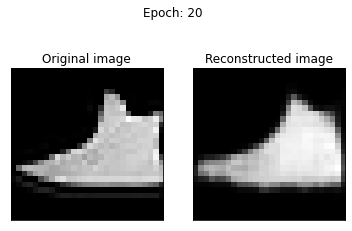

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.015


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.015


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

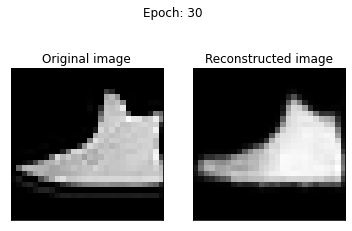

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014


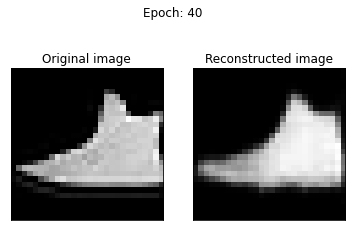

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.014


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

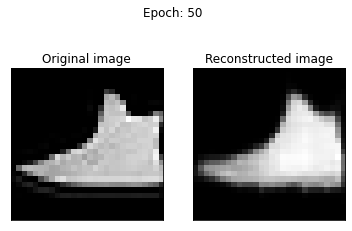

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.014. Signaling Trainer to stop.


In [275]:
data_dir = 'dataset'
best_params = trial.params

# define data module
data_module = Fashion_DataModule(data_dir, 256, train_transform, test_transform)
data_module.prepare_data()
data_module.setup()

# define trainer
metrics_callback = MetricsCallback()
trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_epochs=100,
                     callbacks=[metrics_callback,
                                EarlyStopping(monitor='val_loss', verbose=True, patience=10), 
                                RecImgDuringTrainingCallback(data_module.get_train_item(0)[0].unsqueeze(0), every_n_epochs=10)])

# define model
model = ConvoutionalAutoEncoder(**best_params)

# fit model
trainer.fit(model, data_module)

In [276]:
# save model checkpoint
models_dir = 'models/'
model_name = 'cae'
trainer.save_checkpoint(models_dir+model_name+".ckpt")

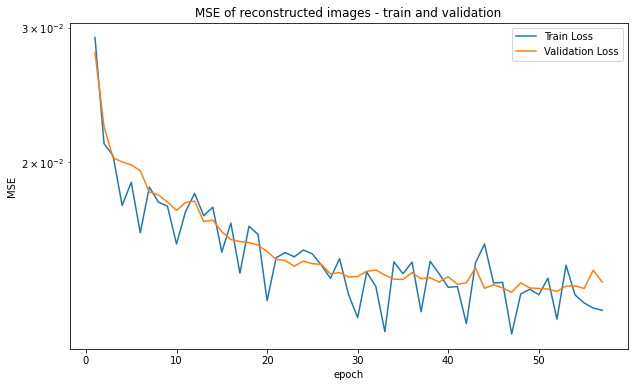

In [277]:
title = "MSE of reconstructed images - train and validation"
metric = "MSE"
plot_metrics(metrics_callback, title, metric, logy=True)

In [ ]:
trainer.test(model, data_module)

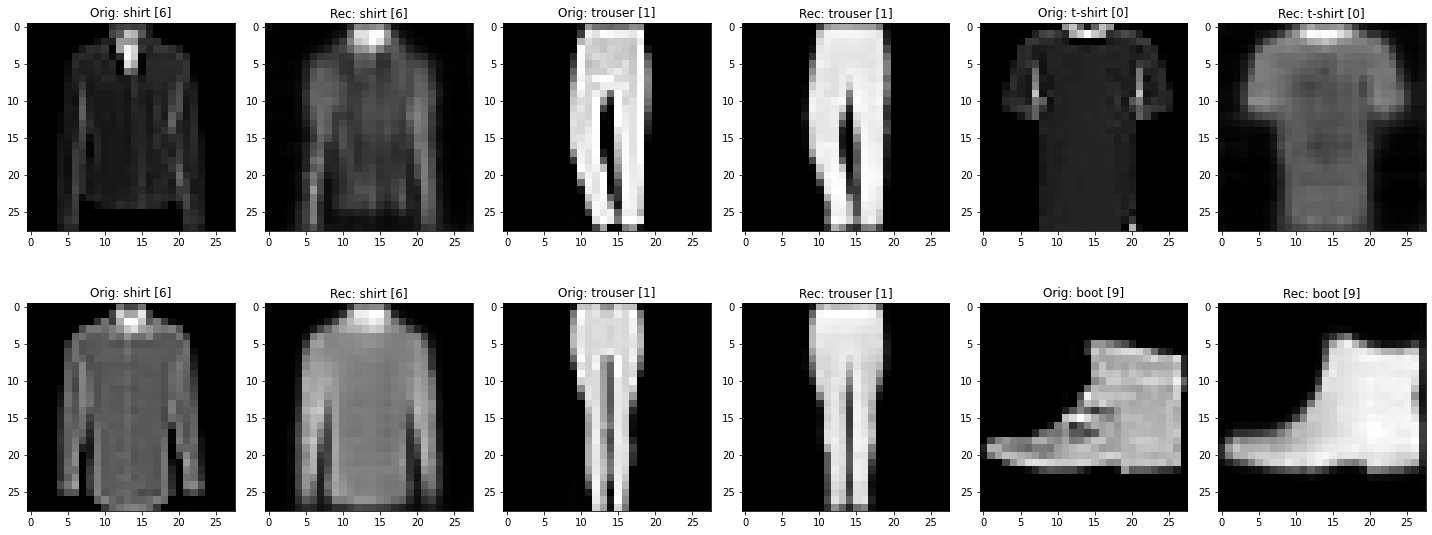

In [278]:
plot_recos(model, data_module, 6)

Thanks to this last plot we notice how, after the hyperparameter optimization routine, the model's performance is for sure improved as similar classes that before were mixed as shirt and t-shirt are now clearly separated.

## Fine tuning for a classfication task

As mentioned in the introduction we are now going to fine tune our autoencoder to perform a supervised task, a classification one. We will use only the encoder part of the autoencoder, uploading its weights from the previous training, and attach at the end of it a feed forward _classifier_ network. This classifier network has a (latent_space_dim, 128, 64, 10) architecture and we will use a classic classification loss, the cross entropy. 

We alos must take care in _freezing_ the parameters that we don't want to train through the optimizer, few code snippets are taken from the official documentation of pl (https://pytorch-lightning.readthedocs.io/en/stable/advanced/transfer_learning.html)

In [279]:
import torchmetrics
import torch.nn.functional as F

In [280]:
class Fashion_Classifier(pl.LightningModule):
    def __init__(self, model_path, optimizer_name='Adam', lr=1e-3, l2_reg=0.0):
        
        super().__init__()

        self.save_hyperparameters()

        # recover autoencoder from checkpoint
        self.autoencoder = ConvoutionalAutoEncoder.load_from_checkpoint(model_path+".ckpt")
        # freeze autoencoder
        self.autoencoder.freeze()
        # extract feature extractor from autoencoder
        self.feature_extractor = self.autoencoder.encoder
        self.latent_space_dim = self.autoencoder.hparams.latent_space_dim

        # define classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.latent_space_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10),
            nn.LogSoftmax()
        )

        # define accuracy metric
        self.metric = torchmetrics.Accuracy()

    def forward(self, x):
        x = self.feature_extractor(x)
        x = self.classifier(x)
        return x

    def training_step(self, batch, batch_idx, log_name='train'):
        x, y = batch

        # extract features
        features = self.feature_extractor(x)

        # classify
        y_hat = self.classifier(features)
        
        # compute loss
        loss = F.cross_entropy(y_hat, y)
        self.log(log_name+'_loss', loss)

        # compute accuracy
        acc = self.metric(y_hat, y)
        self.log(log_name+'_acc', acc)
        
        return loss

    def validation_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx, log_name='val')

    def test_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx, log_name='test')

    def predict_step(self, batch, batch_idx):
        x, _ = batch
        y_hat = self(x)
        return y_hat

    def configure_optimizers(self):
        # get params
        optimizer_name = self.hparams.optimizer_name
        lr = self.hparams.lr
        l2_reg = self.hparams.l2_reg

        optimizer = getattr(optim, optimizer_name)(self.parameters(), lr=lr, weight_decay=l2_reg)
        return optimizer

In [281]:
models_dir = 'models/'
model_name = 'cae'

In [282]:
# define data module
data_module = Fashion_DataModule(data_dir, 256, train_transform, test_transform)
data_module.prepare_data()
data_module.setup()

# define trainer
metrics_callback = MetricsCallback()
trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_epochs=50,
                     callbacks=[metrics_callback,
                                EarlyStopping(monitor='val_loss', verbose=True, patience=10)])

# define model
model = Fashion_Classifier(model_path=models_dir+model_name)

# fit model
trainer.fit(model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name              | Type                    | Params
--------------------------------------------------------------
0 | autoencoder       | ConvoutionalAutoEncoder | 50.3 K
1 | feature_extractor | Sequential              | 25.0 K
2 | classifier        | Sequential              | 10.3 K
3 | metric            | Accuracy                | 0     
--------------------------------------------------------------
10.3 K    Trainable params
50.3 K    Non-trainable params
60.6 K    Total params
0.243     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.488


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.044 >= min_delta = 0.0. New best score: 0.444


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.429


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.421


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.015 >= min_delta = 0.0. New best score: 0.406


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.002 >= min_delta = 0.0. New best score: 0.405


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.008 >= min_delta = 0.0. New best score: 0.396


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.396


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.396


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.392


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.392


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.391


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.005 >= min_delta = 0.0. New best score: 0.386


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.385


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.000 >= min_delta = 0.0. New best score: 0.385


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 0.382


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 0.382


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 0.004 >= min_delta = 0.0. New best score: 0.378


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 10 records. Best score: 0.378. Signaling Trainer to stop.


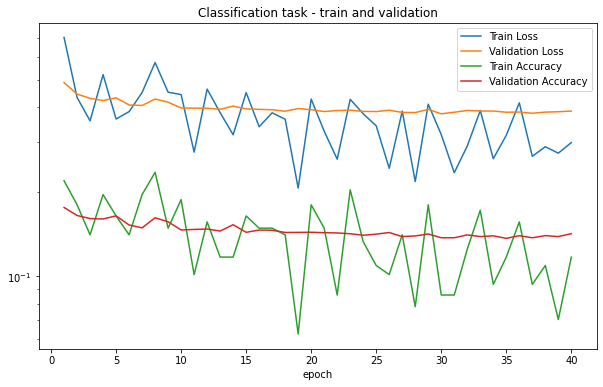

In [283]:
title = "Classification task - train and validation"
metric = ""
plot_metrics(metrics_callback, title, metric, logy=True, acc=True)

It is clear from the training and validation losses plot that there is no a huge increase in beween the first epochs of training, something that is usually common. This is because we are using a pretrained model and we are not performing a full training but only a fine tuning training.

In [284]:
trainer.test(model, data_module)

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8521000146865845
        test_loss           0.41247957944869995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.41247957944869995, 'test_acc': 0.8521000146865845}]

In [285]:
predictions = torch.empty(0)

In [286]:
for pred_batch in trainer.predict(model, data_module):
    predictions = torch.cat((predictions, pred_batch))

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 188it [00:00, ?it/s]

In [287]:
true_labels = [data[1] for data in data_module.test_dataset]
pred_labels = [torch.argmax(prediction) for prediction in predictions]

In [288]:
from sklearn.metrics import ConfusionMatrixDisplay

In [289]:
labels_dict = {
                 0: "T-shirt/Top",
                 1: "Trouser",
                 2: "Pullover",
                 3: "Dress",
                 4: "Coat", 
                 5: "Sandal", 
                 6: "Shirt",
                 7: "Sneaker",
                 8: "Bag",
                 9: "Ankle Boot"
                 }

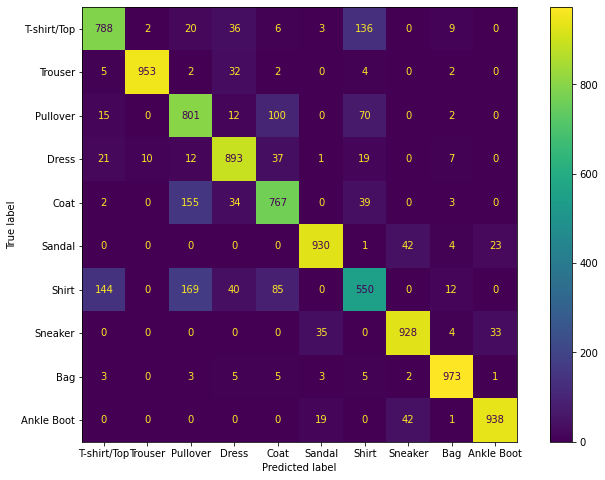

In [290]:
fig, ax = plt.subplots(figsize=(12, 8))
ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels, 
                                        display_labels=labels_dict.values(),
                                        ax=ax)
plt.show()

Thanks to the evaluation of the model over the test set we obtain a similar accuracy in less time, witnessing the fact that transfer learning can be very useful.

## Explore the latent space

Now we are interested in exploring the latent space of the trained model, we can do two directions:
- generating samples from the latent space
- visualizing the latent space

In [291]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [292]:
model_path = 'models/cae'
conv_ae = ConvoutionalAutoEncoder.load_from_checkpoint(model_path+".ckpt")

In [293]:
# retrive latent representations of test set
latent_imgs = []
latent_labels = []
conv_ae.eval()
for img, label in data_module.test_dataset:
    latent_imgs.append(conv_ae.encoder(img.unsqueeze(0)).squeeze(0).detach().numpy())
    latent_labels.append(label)

### Generating fully random samples

One interesting thing can be generating totally random points in the latent space and see their _decoded_ version and if they are similar to some of the known categories.

[  0.02672505  -1.27730296   0.03130103 -14.03287338  12.81111743
  -7.14543874  11.16695988  12.60321232 -19.40790891 -10.89681087]


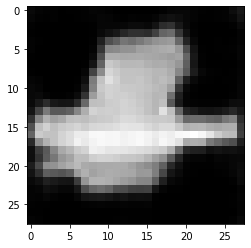

[  8.46926302  12.84451582  11.73301903  -0.19136058   2.42298782
   0.5972308   -8.51946685 -12.47640811  -6.35977457  -9.34762662]


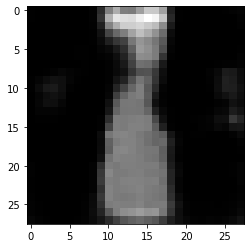

[-11.88764722  -3.69329704   0.84978232 -19.66188519  18.52577413
  14.41897114  11.60099271  10.0857507   17.56729444  19.36893916]


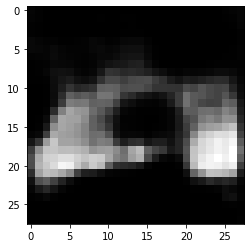

In [294]:
n = 3
np.random.seed(79)
for i in range(n):
    gen_latent_img = np.random.uniform(-20, 20, size=conv_ae.hparams.latent_space_dim)
    print(gen_latent_img)
    plt.imshow(conv_ae.decoder(torch.tensor(gen_latent_img).float().unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy(), cmap='gray')
    plt.show()

### Generating noisy samples

Another intersting thing is to start from the encoded representation of a known sample, add some noise, and see how it changes the _decoded_ version.

Original image: label = Sneaker


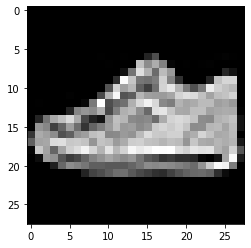

In [295]:
i = 79
original_img, label = data_module.get_train_item(i)
print("Original image: label = {}".format(labels_dict[label]))
plt.imshow(original_img.squeeze(0), cmap='gray')
plt.show()

In [296]:
# retrive latent space representation
latent_img = conv_ae.encoder(original_img.unsqueeze(0)).squeeze(0).detach().numpy()
# generate gaussian noise
t = 1e1  # "temperature" parameter
latent_img_noisy = [x + np.random.randn()*t for x in latent_img]

In [297]:
print(latent_img, "\n", latent_img_noisy)

[ -9.753445   -4.79963    -1.3512074 -16.45213    28.950195  -33.290375
   4.878916    4.6749983   3.5614796   0.867166 ] 
 [-9.081611819282934, -13.338544000379487, -9.350087141486704, -5.661734204577606, 19.24827645700435, -27.183240005623404, 2.901592383753287, 15.987308559119185, -10.303362034424435, 9.311841549732591]


New image


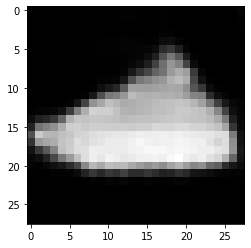

In [298]:
# generate new image
new_img = conv_ae.decoder(torch.tensor(latent_img_noisy).float().unsqueeze(0)).squeeze(0).squeeze(0).detach().numpy()
print("New image")
plt.imshow(new_img, cmap='gray')
plt.show()

### Visualizing the latent space

Having a latent space dimension of 10, visualizing the latent space require a dimension reduction procedure, we will try:
- PCA: a technique that conserve the features with the maximum variability over the dataset7
- t-SNE: a technique that converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data

Both mehtods are implemented in the sklearn package.

In [299]:
pca = PCA(n_components=2)
pca_imgs = pca.fit_transform(latent_imgs)

In [300]:
labels_dict

{0: 'T-shirt/Top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle Boot'}

In [301]:
pca_imgs = pd.DataFrame(pca_imgs, columns=['x', 'y'])
pca_imgs['label'] = latent_labels
pca_imgs['label'] = pca_imgs['label'].map(labels_dict)

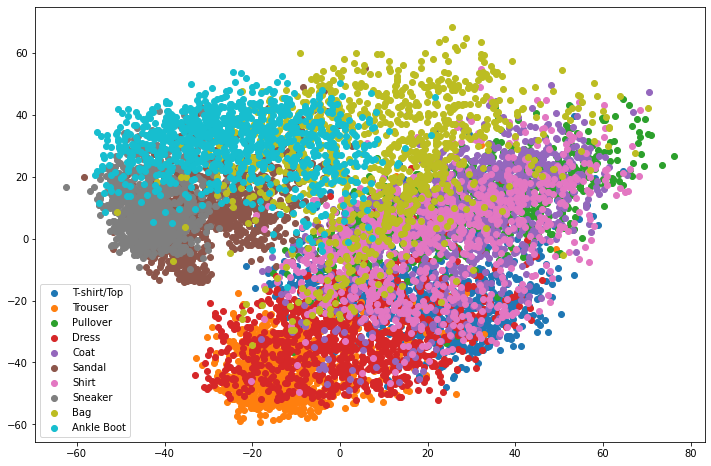

In [302]:
fig, ax = plt.subplots(figsize=(12, 8))
for l in labels_dict.values():
    ax.scatter(pca_imgs[pca_imgs['label']==l]['x'], pca_imgs[pca_imgs['label']==l]['y'], label=l)
plt.legend()
plt.show()

### T-SNE

In [303]:
tsne = TSNE(n_components=2)
tsne_imgs = tsne.fit_transform(latent_imgs)

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [304]:
tnse_imgs = pd.DataFrame(tsne_imgs, columns=['x', 'y'])
tnse_imgs['label'] = latent_labels
tnse_imgs['label'] = tnse_imgs['label'].map(labels_dict)

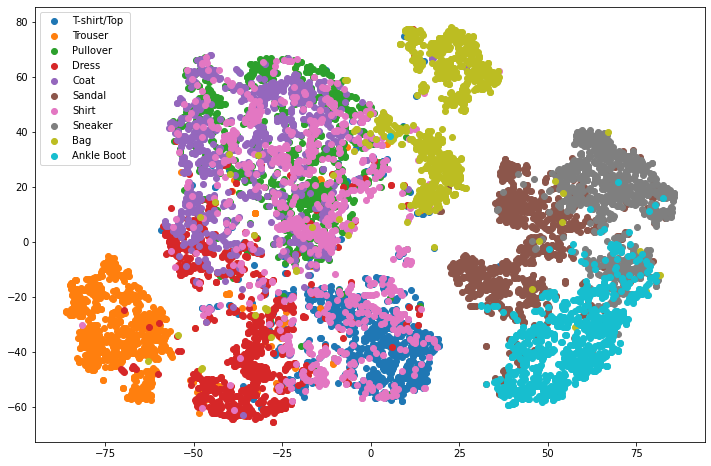

In [305]:
fig, ax = plt.subplots(figsize=(12, 8))
for l in labels_dict.values():
    ax.scatter(tnse_imgs[tnse_imgs['label']==l]['x'], tnse_imgs[tnse_imgs['label']==l]['y'], label=l)
plt.legend()
plt.show()

Through these representations we observe that the classes are somehow clustered in the space but some of them overlaps a lot with the others, for example "shirt" with "t-shirt", "pullover", "dress". This is for sure due to the fact that we are reducing the original number of dimensions to get a visualization of our dataset, maybe some overlaps are also due to a non-optimal model that cannot distinguish classes in some cases.

## Variational autoencoder

As last task of this homework we implement a different kind of autoencoder to tackle the same problem of the initial convolutional autoencoder. The variational autoencoder (VAE) is a variation of the standard autoencoder that we implemented before, if in the standard autoencoder samples are mapped in spaces that can be not regular the variational autoencoder always map samples in regular spaces ensuring a better ability to generalize to unseen examples. This is why they are usually used for data generation purposes.

The main difference is that VAE encodes the sample into a probability space, we want to learn the probability distribution of our data. We define the prior as the underlying distribution of the dataset, usually a standard normal distribution, and the posterior as the probability of the encoding given a data point. The posterior is represented through a multivariate normal distribution encoded by two vectores, mean and variance(we consider a diagonal covariance matrix and so a variance vector). So, instead of bottleneck composed by a layer with number of neurons equal to the _latent_space_dim_, we will have two vectors of _latent_space_dim_ elements that encode the mean and variance of the posterior distribution and we are gonna sample the latent representation from this distribution.

The loss function is composed by two elements:
- the reconstruction loss that take care of minimizing the difference between input and output
- the Kullback-Leibler divergence that measures the difference between prior and posterior and, in our case, is a close form:
$$
D_{KL}(N(\vec{\mu}, diag(\sigma_1 ^2, \dots, \sigma_n ^2)|| N(0, I))) = \frac{1}{2} \sum_{i=1} ^n(\sigma_i ^2 + \mu_i ^2 -1 -ln(\sigma_i ^2))
$$

We must pay attention that the sampling operation is stochastic and gradients cannot backpropagate, what we can do is to use a reparmetrization trick that separate the stochastic and deterministic part of the sampling operation:
$$
\vec{x} \sim N(\vec{\mu}, \vec{\sigma}^2) \rightarrow \vec{z} \sim N(0, I), \vec{x} = \vec{\mu} + z \cdot \vec{\sigma}
$$

In [258]:
class VariationalAutoEncoder(pl.LightningModule):
 
    def __init__(self, latent_space_dim=2, optimizer_name='Adam', lr=1e-3, l2_reg=0.0):

        super().__init__()
                                            
        self.save_hyperparameters()
        
        # encoder
        self.encoder = nn.Sequential(
            # convloutional layers
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=2, padding=1),  
            nn.ReLU(),                                                                            
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1), 
            nn.ReLU(),                                                                          
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=0),            
            nn.ReLU(),           
            # flattening                                                                  
            nn.Flatten(start_dim=1)                                
        )

        # multivariate gaussian distribution
        self.mu = nn.Sequential(
            nn.Linear(in_features=3*3*32, out_features=64),                                            
            nn.ReLU(),                                                                             
            nn.Linear(in_features=64, out_features=self.hparams.latent_space_dim) 
        )
        self.log_var = nn.Sequential(
            nn.Linear(in_features=3*3*32, out_features=64),                                            
            nn.ReLU(),                                                                             
            nn.Linear(in_features=64, out_features=self.hparams.latent_space_dim) 
        )

        # decoder
        self.decoder = nn.Sequential(
            # fully connected layers
            nn.Linear(in_features=self.hparams.latent_space_dim, out_features=64),
            nn.ReLU(),
            nn.Linear(in_features=64, out_features=3*3*32),
            nn.ReLU(),
            # unflattening
            nn.Unflatten(dim=1, unflattened_size=(32, 3, 3)),
            # convloutional layers
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, output_padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    # sampling with reparametrization trick
    def sampling(self, mu, log_var):
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(mu)
        sample = mu + eps*std
        return sample

    def forward(self,  x):
        enc = self.encoder(x)
        mu = self.mu(enc)
        log_var = self.log_var(enc)
        z = self.sampling(mu, log_var)
        return self.decoder(z), mu, log_var

    def training_step(self, batch, batch_idx,  loss_name='train_loss'):
        x, _ = batch # we don't need labels for autoencoder

        # forward pass
        x_hat, mu, log_var = self.forward(x)

        # define & compute loss
        kl_loss = -0.5*torch.sum(1. + log_var - mu**2 - torch.exp(log_var))
        recon_loss = nn.functional.mse_loss(x_hat, x, reduction='sum')
        loss = recon_loss + kl_loss
        self.log(loss_name, loss)

        return loss

    def validation_step(self, batch, batch_idx):
        return self.training_step(batch, batch_idx, loss_name='val_loss')

    def test_step(self, batch, batch_idx):
        return self.validation_step(batch, batch_idx, loss_name='test_loss')

    def configure_optimizers(self):
        # get params
        optimizer_name = self.hparams.optimizer_name
        lr = self.hparams.lr
        l2_reg = self.hparams.l2_reg

        optimizer = getattr(optim, optimizer_name)(self.parameters(), lr=lr, weight_decay=l2_reg)
        return optimizer

In [206]:
class RecImgDuringTrainingCallback(pl.Callback):

    def __init__(self, input_img, every_n_epochs=1):
        super().__init__()
        self.input_img = input_img 
        self.every_n_epochs = every_n_epochs

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            # Reconstruct image
            input_img = self.input_img
            with torch.no_grad():
                pl_module.eval()
                rec_img, _, _ = pl_module(input_img)
                pl_module.train()
                
            input_img = self.input_img.squeeze().cpu().numpy()
            rec_img = rec_img.squeeze().cpu().numpy()
            
            fig, (ax1, ax2) = plt.subplots(1, 2)
            fig.suptitle('Epoch: {}'.format(trainer.current_epoch))
            
            ax1.imshow(input_img, cmap='gist_gray')
            ax1.set_title('Original image')
            ax1.set_xticks([]); ax1.set_yticks([])
            
            ax2.imshow(rec_img, cmap='gist_gray')
            ax2.set_title('Reconstructed image')
            ax2.set_xticks([]); ax2.set_yticks([])
            
            plt.show()

We train the model taking the same latent space dimension as the best model for the convolutional autoencoder and the other parameters setted to some fixed values.

In [211]:
hparams = {'latent_space_dim': 10, 'optimizer_name': 'Adam', 'lr': 1e-2, 'l2_reg': 0}

In [259]:
# define data module
data_module = Fashion_DataModule(data_dir, 256, train_transform, test_transform)
data_module.prepare_data()
data_module.setup()

# define trainer
metrics_callback = MetricsCallback()
trainer = pl.Trainer(gpus=1 if torch.cuda.is_available() else None,
                     max_epochs=100,
                     callbacks=[metrics_callback,
                                EarlyStopping(monitor='val_loss', verbose=True), 
                                ])#RecImgDuringTrainingCallback(data_module.get_train_item(0)[0].unsqueeze(0), every_n_epochs=10)])

# define model
model = VariationalAutoEncoder(9)

# fit model
trainer.fit(model, data_module)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 5.9 K 
1 | mu      | Sequential | 19.1 K
2 | log_var | Sequential | 19.1 K
3 | decoder | Sequential | 25.2 K
---------------------------------------
69.3 K    Trainable params
0         Non-trainable params
69.3 K    Total params
0.277     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/gfrances/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 10817.534


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 2283.602 >= min_delta = 0.0. New best score: 8533.933


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 684.399 >= min_delta = 0.0. New best score: 7849.533


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 336.745 >= min_delta = 0.0. New best score: 7512.788


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 185.863 >= min_delta = 0.0. New best score: 7326.925


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 125.670 >= min_delta = 0.0. New best score: 7201.255


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 112.806 >= min_delta = 0.0. New best score: 7088.449


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 65.135 >= min_delta = 0.0. New best score: 7023.313


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 89.609 >= min_delta = 0.0. New best score: 6933.705


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 77.291 >= min_delta = 0.0. New best score: 6856.414


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 6.136 >= min_delta = 0.0. New best score: 6850.278


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 44.999 >= min_delta = 0.0. New best score: 6805.279


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 67.144 >= min_delta = 0.0. New best score: 6738.135


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 31.058 >= min_delta = 0.0. New best score: 6707.077


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 19.682 >= min_delta = 0.0. New best score: 6687.395


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 18.170 >= min_delta = 0.0. New best score: 6669.224


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 46.623 >= min_delta = 0.0. New best score: 6622.602


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 34.523 >= min_delta = 0.0. New best score: 6588.078


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 46.720 >= min_delta = 0.0. New best score: 6541.358


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 36.312 >= min_delta = 0.0. New best score: 6505.046


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 23.715 >= min_delta = 0.0. New best score: 6481.331


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 5.595 >= min_delta = 0.0. New best score: 6475.736


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 8.103 >= min_delta = 0.0. New best score: 6467.633


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.715 >= min_delta = 0.0. New best score: 6463.918


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 3.917 >= min_delta = 0.0. New best score: 6460.001


Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 10.231 >= min_delta = 0.0. New best score: 6449.771


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Metric val_loss improved by 36.489 >= min_delta = 0.0. New best score: 6413.281


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Monitored metric val_loss did not improve in the last 3 records. Best score: 6413.281. Signaling Trainer to stop.


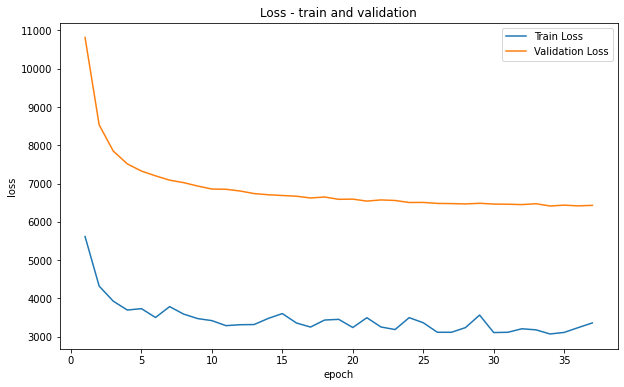

In [261]:
title = "Loss - train and validation"
metric = "loss"
plot_metrics(metrics_callback, title, metric, logy=False)

In [ ]:
trainer.test(model, data_module)

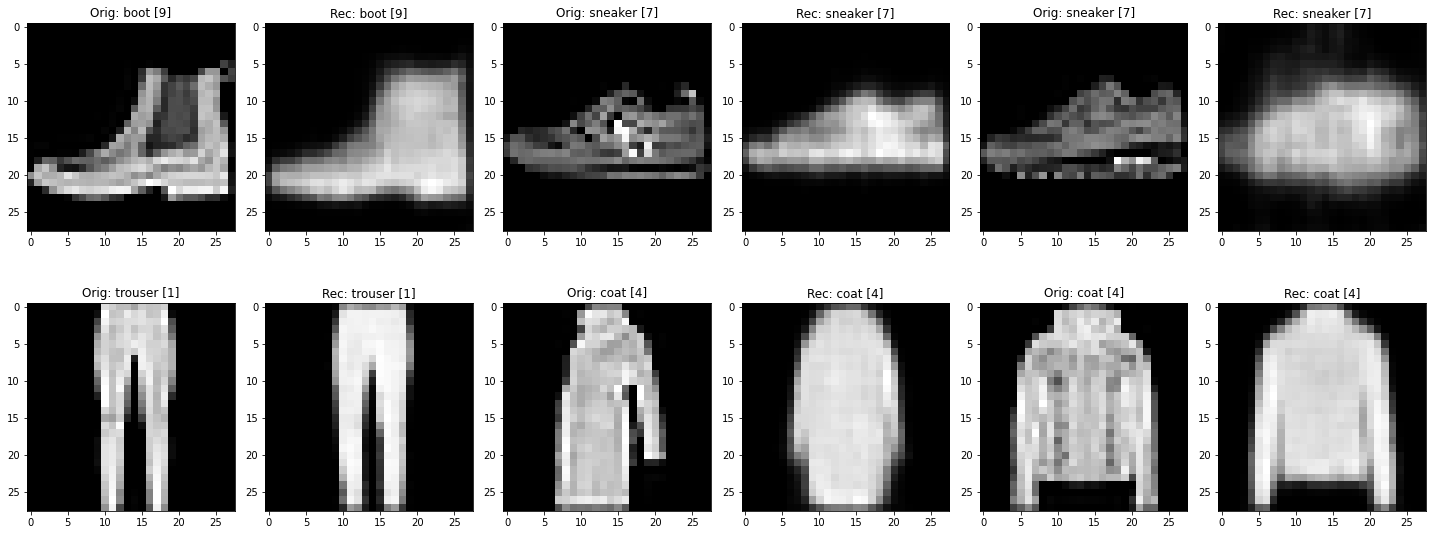

In [264]:
plot_recos(model, data_module, 6, variational=True)